In [53]:
import numpy as np
import importlib
import matplotlib as mpl
import matplotlib.pylab as plt
import time
from copy import deepcopy
import torch
import IPython.display as IPd
import pandas as pd
import dill as pickle

from stg_energy.common import col, svg, samples_nd, get_labels_8pt
from stg_energy.fig5_cc.viz import vis_sample_plain
from pyloric import simulate, summary_stats, create_prior
from stg_energy.fig7_temp.process_samples import merge_samples
import stg_energy.fig7_temp.viz as viz
from sbi.analysis import ActiveSubspace

from stg_energy import check_if_close_to_obs

import pyabf

# Fig 7: posterior over temperatures

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PANEL_exp1 = '../svg/panel_exp1.svg'
PANEL_exp2 = '../svg/panel_exp2.svg'

PANEL_exp1_spikes = '../svg/panel_exp1_spikes.svg'
PANEL_exp2_spikes = '../svg/panel_exp2_spikes.svg'

PANEL_A1 = '../svg/panel_a1.svg'
PANEL_A2 = '../svg/panel_a2.svg'

PANEL_B1 = '../svg/panel_b1.svg'
PANEL_B2 = '../svg/panel_b2.svg'

PANEL_C1 = '../svg/panel_c1.svg'
PANEL_C2 = '../svg/panel_c2.svg'
PANEL_C3 = '../svg/panel_c3.svg'

PANEL_D1 = '../svg/panel_d1.svg'
PANEL_D2 = '../svg/panel_d2.svg'

PANEL_E1 = '../svg/panel_e1.svg'
PANEL_E2 = '../svg/panel_e2.svg'
PANEL_E3 = '../svg/panel_e3.svg'
PANEL_E4 = '../svg/panel_e4.svg'

PANEL_F = '../svg/panel_f.svg'
PANEL_G = '../svg/panel_g.svg'

In [4]:
prior_11 = create_prior(as_torch_dist=True)
prior_27 = create_prior(
    customization={
        "Q10_gbar_mem": [True, True, True, True, True, True, True, True],
        "Q10_gbar_syn": [True, True],
        "Q10_tau_m": [False],
        "Q10_tau_h": [False],
        "Q10_tau_CaBuff": [False],
        "Q10_tau_syn": [False, False],
    },
    as_torch_dist=True
)
prior_27_lower = prior_27.support.lower_bound
prior_27_upper = prior_27.support.upper_bound
lims_27 = np.asarray([prior_27_lower.numpy(), prior_27_upper.numpy()]).T

### Load samples from 11 deg, 15deg, 19deg, 23deg, 27deg

In [5]:
xo11 = np.load("../../../results/experimental_data/xo_11deg.npy")
xo27 = np.load("../../../results/experimental_data/xo_27deg.npy")

npz = np.load("../../../results/experimental_data/trace_data_845_082_0044.npz")
t = npz["t"]

In [6]:
sims_p = "../../../results/simulation_data_Tube_MLslurm_cluster/"

In [7]:
theta_11_11_close = pd.read_pickle(sims_p+"close_to_xo_circuit_parameters.pkl")
x_11_11_close = pd.read_pickle(sims_p+"close_to_xo_simulation_outputs.pkl")
seeds_11_11_close = np.load(sims_p+"close_to_xo_seeds.npy")

theta_11_11_close_np = theta_11_11_close.to_numpy()
x_11_11_close_np = x_11_11_close.to_numpy()

In [8]:
theta_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_circuit_parameters.pkl")
x_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_simulation_outputs.pkl")
seeds_27_11 = np.load(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_seeds.npy")

theta_27_11_np = theta_27_11.to_numpy()
x_27_11_np = x_27_11.to_numpy()

In [9]:
theta_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_circuit_parameters.pkl")
x_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_simulation_outputs.pkl")
seeds_27_27 = np.load(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_seeds.npy")

theta_27_27_np = theta_27_27.to_numpy()
x_27_27_np = x_27_27.to_numpy()

In [22]:
condition_rejection_nan = pd.read_pickle(sims_p+"simulate_11deg_R3_predictives_at_27deg_notau_only_close/data/simulation_outputs/sim_0.pkl")
condition_rejection_nan_np = condition_rejection_nan.to_numpy()

condition_rejection = np.invert(np.any(np.isnan(condition_rejection_nan_np), axis=1))

x_11_11_rejection_nan = x_11_11_close[condition_rejection]
x_11_11_rejection_nan = x_11_11_rejection_nan.loc[x_11_11_rejection_nan['pyloric_like']['Circuit'] == 1.0]
x_11_11_rejection_nan_np = x_11_11_close_np[condition_rejection]

In [23]:
x_11_11_rejection_nan_np.shape

(11983, 34)

In [55]:
with open("../../../results/trained_neural_nets/inference/posterior_27deg_notau_082.pickle", "rb") as handle:
    posterior = pickle.load(handle)
    posterior._device = "cpu"

### Check if theta at 11 and 27 predictives are indeed the same

In [25]:
test_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/circuit_parameters/sim_0.pkl")
test_27_11_np = test_27_11.to_numpy()

In [26]:
test_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/circuit_parameters/sim_0.pkl")
test_27_27_np = test_27_27.to_numpy()

### Select only those stats that were sufficiently close at 11 and 27 degree

In [27]:
close_at_11 = check_if_close_to_obs(x_27_11_np)

In [28]:
close_at_27 = check_if_close_to_obs(x_27_27_np, xo=xo27[:15])

In [29]:
close_at_both = np.asarray([c1 and c2 for c1, c2 in zip(close_at_11, close_at_27)])

In [30]:
x_27_27_close = x_27_27[close_at_both]
theta_27_27_close = theta_27_27[close_at_both]
seeds_27_27_close = seeds_27_27[close_at_both]

x_27_27_close_np = x_27_27_np[close_at_both]
theta_27_27_close_np = theta_27_27_np[close_at_both]

In [31]:
x_27_11_close = x_27_11[close_at_both]
theta_27_11_close = theta_27_11[close_at_both]
seeds_27_11_close = seeds_27_11[close_at_both]

x_27_11_close_np = x_27_11_np[close_at_both]
theta_27_11_close_np = theta_27_11_np[close_at_both]

In [32]:
np.sum(close_at_both)

6131

### Reset indizes to start at 1

In [33]:
x_27_11_close.index = np.arange(len(x_27_11_close))
theta_27_11_close.index = np.arange(len(theta_27_11_close))

x_27_27_close.index = np.arange(len(x_27_27_close))
theta_27_27_close.index = np.arange(len(theta_27_27_close))

# Plot experimental data

In [34]:
npz = np.load('../../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

In [35]:
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

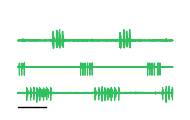

In [36]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+pdn[start_index:end_index]*0.007, c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 1.2+lpn[start_index:end_index]*0.25, c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], -0.1+pyn[start_index:end_index]*0.013, c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)
    
    plt.savefig(PANEL_exp1, facecolor='None', transparent=True)
    plt.show()

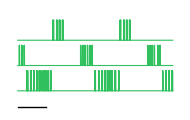

In [37]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+PD_spikes[start_index:end_index], c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 1.25+LP_spikes[start_index:end_index], c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], PY_spikes[start_index:end_index], c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)
    
    plt.savefig(PANEL_exp1_spikes, facecolor='None', transparent=True)
    plt.show()

In [38]:
name = '845_082_0064'
datafile = "../../../results/experimental_data/"+name+".abf"
abf = pyabf.ABF(datafile)

In [39]:
channel_names = abf.adcNames
channel_data = abf.data

In [40]:
LPN = channel_data[3]
PYN = channel_data[1]
PDN = channel_data[2]
LVN = channel_data[6]
sampling_frequency = abf.dataRate

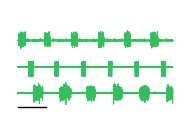

In [41]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+PDN[start_index:end_index]*0.007, c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 1.2+LPN[start_index:end_index]*0.25, c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], -0.1+PYN[start_index:end_index]*0.013, c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])

    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)

    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)

    plt.savefig(PANEL_exp2, facecolor='None', transparent=True)
    plt.show()

In [42]:
npz = np.load('../../../results/experimental_data/data_845_082_0064.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']

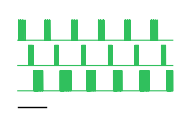

In [43]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+PD_spikes[start_index:end_index], c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 1.25+LP_spikes[start_index:end_index], c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], PY_spikes[start_index:end_index], c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])

    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)

    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)

    plt.savefig(PANEL_exp2_spikes, facecolor='None', transparent=True)
    plt.show()

# Plot posteriors

In [44]:
labels_ = get_labels_8pt()
labels_[9] += ''

/home/michael/Documents/STG_energy/stg_energy/common.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


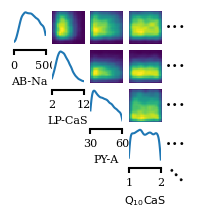

In [45]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    q10_samples = prior_27.sample((theta_11_11_close_np.shape[0],)).numpy()[:, -10:]
    sample_params_11_q10 = np.concatenate((theta_11_11_close_np, q10_samples), axis=1)
    _ = samples_nd(
        samples=sample_params_11_q10[:10000],
        subset=[0,10,19,33],
        upper=['kde'],
        diag=['kde'],
        fig_size=(1.9, 1.9),
        limits=lims_27,
        ticks=lims_27,
        labels=labels_,
    )
    plt.savefig(PANEL_A1, facecolor='None', transparent=True)

/home/michael/Documents/STG_energy/stg_energy/common.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


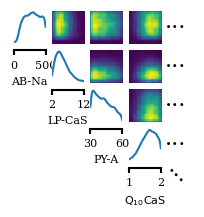

In [46]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    sample_params_27_norm = theta_27_27_np
    _ = samples_nd(
        samples=sample_params_27_norm[:10000],
        subset=[0,10,19,33],
        upper=['kde'],
        diag=['kde'],
        fig_size=(1.9, 1.9),
        limits=lims_27,
        ticks=lims_27,
        labels=labels_,
    )
    plt.savefig(PANEL_A2, facecolor='None', transparent=True)

# Plot a sample from the 27deg posterior across temperatures

In [47]:
time_vec = np.arange(0, 11000, 0.025)

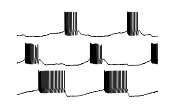

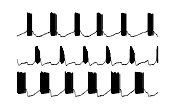

In [48]:
sample_index = 3
counter = 0
offsets = [82000, 16500]

for temp in [283, 299]:

    out_target = simulate(
        theta_27_27_close.loc[sample_index],
        seed=int(seeds_27_27_close[sample_index]),
        temperature=temp,
    )

    with mpl.rc_context(fname="../../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(2.0, 1.15))
        fig = vis_sample_plain(
            out_target,
            time_vec,
            ax,
            time_len=int(shown_t / 0.025 * 1000),
            col='k',
            offset=offsets[counter],
            scale_bar=False,
        )
        if temp == 283:
            plt.savefig(PANEL_B1, facecolor='None', transparent=True)
        elif temp == 299:
            plt.savefig(PANEL_B2, facecolor='None', transparent=True)
        plt.show()
        counter += 1

In [49]:
e_11 = np.sum(x_27_11_close['energies'].to_numpy(), axis=1) / 10 / 1000
e_27 = np.sum(x_27_27_close['energies'].to_numpy(), axis=1) / 10 / 1000

In [50]:
print("Pearson correlation coefficient between energy consumption at 11 and 27 degree: ", np.corrcoef(e_11, e_27)[0, 1])

Pearson correlation coefficient between energy consumption at 11 and 27 degree:  0.6305378864155537


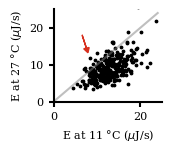

In [51]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.2))
    ax.scatter(e_11[500:800], e_27[500:800], s=3, c='k')
    ax.plot([0, 24], [0, 24], c='gray', alpha=0.5)
    ax.set_xlabel("E at 11 °C ($\mu$J/s)")
    ax.set_ylabel("E at 27 °C ($\mu$J/s)")
    ax.arrow(6.6, 18, 0.98, -3.5, head_width=1.3, head_length=1.3, facecolor="#d7301f", edgecolor='#d7301f')
    ax.set_xlim([0, 25])
    ax.set_ylim([0, 25])
    plt.savefig(PANEL_F, facecolor='None', transparent=True)

In [56]:
_ = torch.manual_seed(0)
sensitivity = ActiveSubspace(posterior.set_default_x(xo27))

theta_27_27_train = torch.as_tensor(theta_27_27_close_np[40:], dtype=torch.float32)
energies_train = torch.as_tensor(np.sum(x_27_27_close['energies'].to_numpy()[40:], axis=1), dtype=torch.float32).unsqueeze(1)

converged_nn = sensitivity.add_property(
    theta_27_27_train,
    energies_train, 
    hidden_features=20, 
    num_blocks=1).train()

e_vals, e_vecs = sensitivity.find_active()


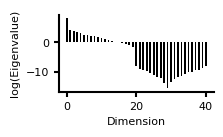

In [57]:
from stg_energy.fig3_amortize_energy.viz import plot_eigenvalues

with mpl.rc_context(fname="../../../.matplotlibrc"):
    plot_eigenvalues(torch.log(torch.abs(torch.flip(e_vals, dims=(0,)))), figsize=(2.0, 1.0), color='k')
    plt.show()

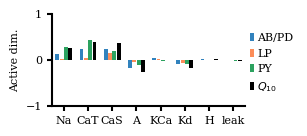

In [58]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_q10(
        e_vecs[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 1.2),
        ylabel="Active dim.",
        plot_labels=True,
        title='',
    )
    plt.savefig(PANEL_G, facecolor='None', transparent=True)

# Show speed-up

### Simulate 3 parameter sets at every temperature from 11 to 27 degree

In [59]:
all_durs_each_set = []
all_stats_each_set = []
skip_steps = 1
for index in range(3, 4):
    all_cycle_durs = []
    all_stats = []
    for temp in range(283, 300, skip_steps):
        out_target = simulate(
            theta_27_27_close.loc[index],
            temperature=temp,
            seed=0,
        )

        summstats = summary_stats(out_target).to_numpy()[0]
        all_cycle_durs.append(summstats[0])
        all_stats.append(summstats[:15])
    all_durs_each_set.append(all_cycle_durs)
    all_stats_each_set.append(all_stats)
all_durs_each_set = np.asarray(all_durs_each_set)
all_stats_each_set = np.asarray(all_stats_each_set)

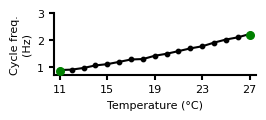

In [60]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.6, 0.8))
    xaxis = np.arange(11, 28, skip_steps)
    for traces in all_durs_each_set:
        ax.plot(xaxis, 1./traces*1000, 'k')
    for traces in all_durs_each_set:
        ax.scatter(xaxis, 1./traces*1000, s=10, c='k', zorder=1000)

    ax.scatter(11, 1/xo11[0]*1000, s=30, color='green', zorder=10000)
    ax.scatter(27, 1/xo27[0]*1000, s=30, color='green', zorder=10000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([10.5, 27.5])
    ax.set_xticks([11, 15, 19, 23, 27])
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Cycle freq.\n(Hz)")
    ax.set_ylim([0.70, 3])
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

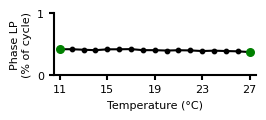

In [61]:
phase_LP = all_stats_each_set[:, :, 7]
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.6, 0.8))
    xaxis = np.arange(11, 28, skip_steps)
    for traces in phase_LP:
        ax.plot(xaxis, traces, 'k')
    for traces in phase_LP:
        ax.scatter(xaxis, traces, s=10, c='k', zorder=1000)

    ax.scatter(11, xo11[7], s=30, color='green', zorder=1000000)
    ax.scatter(27, xo27[7], s=30, color='green', zorder=1000000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([10.5, 27.5])
    ax.set_xticks([11, 15, 19, 23, 27])
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Phase LP\n(% of cycle)")
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

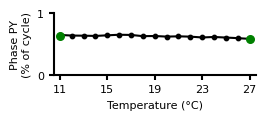

In [62]:
phase_PY = all_stats_each_set[:, :, 8]
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.6, 0.8))
    xaxis = np.arange(11, 28, skip_steps)
    for traces in phase_PY:
        ax.plot(xaxis, traces, 'k')
    for traces in phase_PY:
        ax.scatter(xaxis, traces, s=10, c='k', zorder=1000)

    ax.scatter(11, xo11[8], s=30, color='green', zorder=1000000)
    ax.scatter(27, xo27[8], s=30, color='green', zorder=1000000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([10.5, 27.5])
    ax.set_xticks([11, 15, 19, 23, 27])
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Phase PY\n(% of cycle)")
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 1])
    plt.savefig(PANEL_C3, facecolor='None', transparent=True)
    plt.show()

# Relation between energy efficiency and temperature robustness

### Load samples from 27deg posterior. Samples have been rejected if too far from obs at 11deg and then been simulated at 27deg

In [63]:
all_total_energies_11 = x_11_11_close['energies'].to_numpy()
all_total_energies_27 = x_27_11_close['energies'].to_numpy()
all_total_energies_rejection = x_11_11_rejection_nan['energies'].to_numpy()

In [64]:
summed_energies_total_11 = np.sum(np.asarray(all_total_energies_11), axis=1) / 10 / 1000 # per second, micro-Joule
summed_energies_total_27 = np.sum(np.asarray(all_total_energies_27), axis=1) / 10 / 1000
summed_energies_total_27_rejection = np.sum(np.asarray(all_total_energies_rejection), axis=1) / 10 / 1000

In [65]:
summed_energies_total_11.shape

(35939,)

In [66]:
summed_energies_total_27.shape

(6131,)

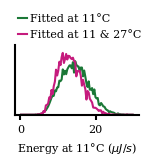

In [89]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.9))

    hist_vals_11 = ax.hist(summed_energies_total_11[:6131], range=(0, 30), bins=100, color='w')
    hist_vals_27 = ax.hist(summed_energies_total_27[:6131], range=(0, 30), bins=100, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#c51b7d')
    ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0, 260])
    ax.set_yticks([])

    plt.legend((line11[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11 & 27°C'), bbox_to_anchor=(0.6, 1.1, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

    plt.savefig(PANEL_D1, facecolor='None', transparent=True)

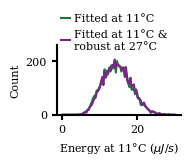

In [90]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.9))

    hist_vals_11 = ax.hist(summed_energies_total_11[:6131], range=(0, 30), bins=100, color='w')
    hist_vals_27 = ax.hist(summed_energies_total_27_rejection[:6131], range=(0, 30), bins=100, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#762a83')
    ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0, 260])

    plt.legend((line11[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11°C & \nrobust at 27°C'), bbox_to_anchor=(0.5, 1.1, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

    plt.savefig(PANEL_D2, facecolor='None', transparent=True)

# Compose figure

In [91]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [92]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "12.5cm",

    Panel(
          SVG(PANEL_exp1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", 0.0*factor_svg, 4.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, -2*factor_svg),

    Panel(
          SVG(PANEL_exp2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(0*factor_svg, 16*factor_svg),
           
    Panel(
          SVG(PANEL_A1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(38*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_A2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(71*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(110*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(110*factor_svg, 18*factor_svg),

    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("d", 0.0*factor_svg, 1.1*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 38*factor_svg),

    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(47*factor_svg, 38*factor_svg),

    Panel(
          SVG(PANEL_C3).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(96*factor_svg, 38*factor_svg),
    
    Panel(
          SVG(PANEL_F).scale(svg_scale).move(0*factor_svg,0*factor_svg),
         Text("e", -1.0*factor_svg, 0.5*factor_svg, **kwargs_text),
    ).move(1*factor_svg, 62*factor_svg),
    
    Panel(
          SVG(PANEL_G).scale(svg_scale).move(0*factor_svg,0*factor_svg),
         Text("f", 0.0*factor_svg, 1.1*factor_svg, **kwargs_text),
    ).move(32.5*factor_svg, 61.45*factor_svg),

    Panel(
          SVG(PANEL_D2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("g", 0.5*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(86*factor_svg, 59.89*factor_svg),

    Panel(
          SVG(PANEL_D1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(116*factor_svg, 59.8*factor_svg),

)

!mkdir -p fig
f.save("../fig/fig4.svg")
svg('../fig/fig4.svg')